# Исследование тарифов оператора сотовой связи

## Оглавление
* [Обзор данных](#о_д)
* [Подготовка данных](#п_д)
* [Исследование данных](#и_д)
    * [Подсчёт выручки](#п_в)
    * [Анализ использования услуг](#а_и)
    * [Предварительные выводы](#п_вы)
* [Проверка гипотез](#п_г)
    * [Проверка гипотезы: средняя выручка от пользователей тарифов «Ультра» и «Смарт» различается](#п_г1)
    * [Проверка гипотезы: средняя выручка с пользователей из Москвы отличается от выручки с пользователей других регионов](#п_г2)
* [Выводы](#в)

## Обзор данных <a class="anchor" id="о_д"></a>

Импортитруем необходимые библиботеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

Откроем файлы с данными и изучим общую информацию о них. Начнём с `calls.csv`.

In [2]:
calls = pd.read_csv('datasets/03/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


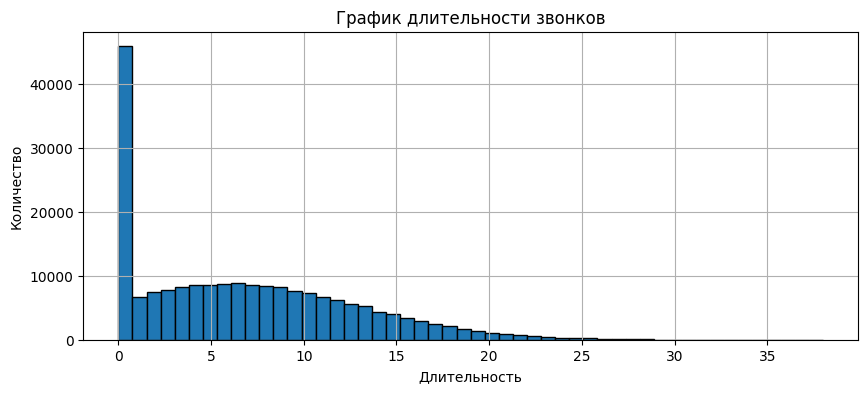

In [4]:
calls['duration'].hist(bins=50, edgecolor='black', figsize=(10, 4));

plt.xlabel('Длительность')
plt.ylabel('Количество')
plt.title('График длительности звонков')
plt.show()

Пропуски отсутствуют, на первый взгляд данные записаны корректно. Много звонков с нулевой продолжительностью, это пропущенные звонки. В дальнейшем столбец `call_date` приведём к формату `datetime()`, а `duration` округлим и приведём к типу `int`. Теперь посмотрим на `internet.csv`.

In [5]:
sessions = pd.read_csv('datasets/03/internet.csv', index_col=0)
sessions.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [6]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


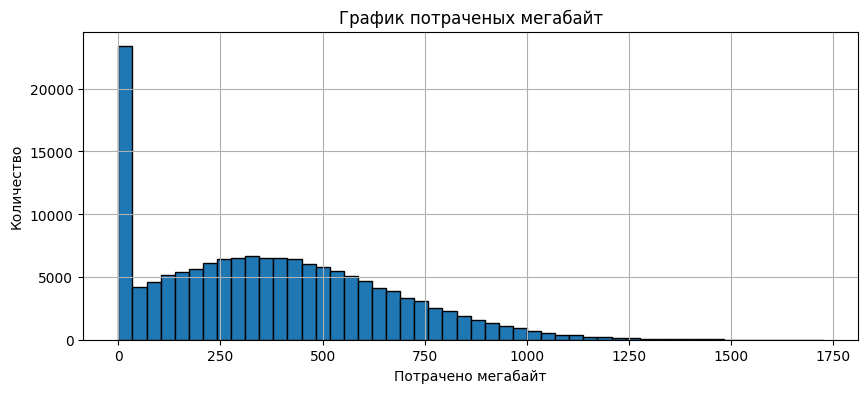

In [7]:
sessions['mb_used'].hist(bins=50, edgecolor='black', figsize=(10, 4));

plt.xlabel('Потрачено мегабайт')
plt.ylabel('Количество')
plt.title('График потраченых мегабайт')
plt.show()

С `internet.csv` ситуация аналогичная. Изучим `messages.csv`.

In [8]:
messages = pd.read_csv('datasets/03/messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Пропуски отсутсвутют, `message_date` приведём к `datetime()`. Посмотрим, как описаны тарифы в `tariffs.csv`.

In [10]:
tariffs = pd.read_csv('datasets/03/tariffs.csv')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Тарифы описаны в соответствии с документацией. Остался `users.csv`.

In [12]:
users = pd.read_csv('datasets/03/users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Пропуски в `churn_date` означают, что тариф ещё действует. `reg_date` и `churn_date` также приведём к `datetime()`.

## Подготовка данных <a class="anchor" id="п_д"></a>

Приведём все даты к `datetime()`.

In [14]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
sessions['session_date'] = pd.to_datetime(sessions['session_date'], format = '%Y-%m-%d')

Округлим `duration` в `calls` и приведём к `int`.

In [15]:
calls['duration'] =  np.ceil(calls['duration']).astype(int)

Создадим стоблцы с номером месяца в `calls`, `messages` и `sessions`.

In [16]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
sessions['month'] = sessions['session_date'].dt.month

Посчитаем количество сделанных звонков для каждого пользователя по месяцам.

In [17]:
calls_per_month = calls.groupby(['user_id', 'month']).agg(calls=('duration', 'count'))
print(calls_per_month.head(10))

               calls
user_id month       
1000    5         22
        6         43
        7         47
        8         52
        9         58
        10        57
        11        43
        12        46
1001    11        59
        12        63


Посчитаем количество израсходованных минут разговора для каждого пользователя по месяцам и сохраним в переменную `minutes_per_month`.

In [18]:
minutes_per_month = calls.groupby(['user_id', 'month']).agg(minutes=('duration', 'sum'))
print(minutes_per_month.head(10))

               minutes
user_id month         
1000    5          159
        6          172
        7          340
        8          408
        9          466
        10         350
        11         338
        12         333
1001    11         430
        12         414


Посчитаем количество отправленных сообщений по месяцам для каждого пользователя и сохраним в переменную `messages_per_month`.

In [19]:
messages_per_month = messages.groupby(['user_id', 'month']).agg(messages=('message_date', 'count'))
print(messages_per_month.head(10))

               messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
        10           73
        11           58
        12           70
1002    6             4
        7            11


Посчитаем количество потраченных мегабайт по месяцам для каждого пользователя и сохраниим в переменную `sessions_per_month`.

In [20]:
sessions_per_month = sessions.groupby(['user_id', 'month']).agg({'mb_used': 'sum'})
print(sessions_per_month.head(10))

                mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
        10     14702.49
        11     14756.47
        12      9817.61
1001    11     18429.34
        12     14036.66


## Исследование данных <a class="anchor" id="и_д"></a>

Цель исследования данных в данном проекте - посчитать выручку с пользователей каждого тарифа, чтобы оценить прибыльность каждого тарифа, и сравнить тарифы по интенсивности использования пользователями услуг. Выручка расчитывается так:
* отнять бесплатный лимит от суммарного количества звонков, сообщений и интернет-трафика;
* остаток умножить на значение из тарифного плана;
* к результату прибавить абонентскую плату, соответствующую тарифному плану.

Для сравнения тарифов по интенсивности использования пользователями услуг построим графики распределения количества звонков, продолжительности звонков, количества сообщений и количества потраченного трафика (Мб) по видам тарифов и месяцам, а так же гистограммы использования услуг по количеству клиентов.

### Подсчёт выручки <a class="anchor" id="п_в"></a>

Объединим все посчитанные выше значения в один датафрейм `user_behavior`, сгруппировав данные по пользователям по месяцам. Для каждой пары "пользователь - месяц" будут доступны информация о тарифе, количестве звонков, сообщений и потраченных мегабайтах.

In [21]:
user_behavior = calls_per_month\
    .merge(messages_per_month, left_index=True, right_index=True, how='outer')\
    .merge(sessions_per_month, left_index=True, right_index=True, how='outer')\
    .merge(minutes_per_month, left_index=True, right_index=True, how='outer')\
    .reset_index()\
    .merge(users, how='left', left_on='user_id', right_on='user_id')\

user_behavior.head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,22.0,2253.49,159.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,60.0,23233.77,172.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,75.0,14003.64,340.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,81.0,14055.93,408.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,57.0,14568.91,466.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Проверим пропуски в таблице `user_behavior` после объединения.

In [22]:
user_behavior.isna().sum()

user_id          0
month            0
calls           40
messages       497
mb_used         11
minutes         40
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
dtype: int64

Заполним образовавшиеся пропуски в данных на `0`, так как пропуски в столбцах означают отсутствие активности пользователя.

In [23]:
user_behavior['calls'] = user_behavior['calls'].fillna(0)
user_behavior['minutes'] = user_behavior['minutes'].fillna(0)
user_behavior['messages'] = user_behavior['messages'].fillna(0)
user_behavior['mb_used'] = user_behavior['mb_used'].fillna(0)

Присоединим информацию о тарифах.

In [24]:
tariffs = tariffs.rename(
    columns={
        'tariff_name': 'tariff'
    }
)

user_behavior = user_behavior.merge(tariffs, on='tariff')

Сравним количество пользователей обоих тарифов.

In [25]:
user_behavior['tariff'].value_counts(normalize=True)

tariff
smart    0.693528
ultra    0.306472
Name: proportion, dtype: float64

`Смарт` в два раза популярнее. Посчитаем количество минут разговора, сообщений и мегабайт, превышающих включенные в тариф.

In [26]:
user_behavior['paid_minutes'] = user_behavior['minutes'] - user_behavior['minutes_included']
user_behavior['paid_messages'] = user_behavior['messages'] - user_behavior['messages_included']
user_behavior['paid_mb'] = user_behavior['mb_used'] - user_behavior['mb_per_month_included']

for col in ['paid_messages', 'paid_minutes', 'paid_mb']:
    user_behavior.loc[user_behavior[col] < 0, col] = 0

Переводём превышающие тариф мегабайты в гигабайты и сохраняем в столбец `paid_gb`.

In [27]:
user_behavior['paid_gb'] = np.ceil(user_behavior['paid_mb'] / 1024).astype(int)

Посчитаем выручку за минуты разговора, сообщения и интернет.

In [28]:
user_behavior['cost_minutes'] = user_behavior['paid_minutes'] * user_behavior['rub_per_minute']
user_behavior['cost_messages'] = user_behavior['paid_messages'] * user_behavior['rub_per_message']
user_behavior['cost_gb'] = user_behavior['paid_gb'] * user_behavior['rub_per_gb']

Посчитаем помесячную выручку с каждого пользователя, она будет храниться в столбце `total_cost`.

In [29]:
user_behavior['total_cost'] = \
      user_behavior['rub_monthly_fee']\
    + user_behavior['cost_minutes']\
    + user_behavior['cost_messages']\
    + user_behavior['cost_gb']

Посмотрим на среднюю выручку с каждого тарифа по услугам.

In [30]:
user_behavior.groupby('tariff').agg({'rub_monthly_fee': 'mean',
                                     'cost_minutes': 'mean',
                                     'cost_messages': 'mean',
                                     'cost_gb': 'mean',
                                     'total_cost': 'mean'}).round(2)

,rub_monthly_fee,cost_minutes,cost_messages,cost_gb,total_cost
tariff,,,,,
smart,550.0,124.82,17.4,597.76,1289.97
ultra,1950.0,0.00,0.0,120.15,2070.15


Анализ этого пункта вынесен в **Предварительные выводы** этого раздела. Исходя из таблицы можно сделать предположение, что *средняя выручка от пользователей тарифов «Ультра» и «Смарт» различается*. Теперь интересно сравнить прибыль от пользователей из Москвы и из других городов.

In [31]:
user_behavior['is_Moscow'] = user_behavior['city'] == 'Москва'
user_behavior.groupby('is_Moscow')['total_cost'].mean()

is_Moscow
False    1524.936227
True     1546.713584
Name: total_cost, dtype: float64

Средние выручки довольно близки. Необходимо проверить *отличается ли средняя выручка от пользователей в Москве от выручки от пользователей в других регионах*.

### Анализ использования услуг <a class="anchor" id="а_и"></a>

Теперь сравним тарифы по интенсивности использования услуг пользователями. Создадим датафрейм `stats_df`, который для каждой пары "месяц-тариф" будет хранить основные характеристики.

In [32]:
stats_df = user_behavior.pivot_table(
            index=['month', 'tariff'],\
            values=['calls', 'minutes', 'messages', 'mb_used'],\
            aggfunc=['mean', 'std', 'median']\
).round(2).reset_index()
stats_df.head()

month tariff   mean                               std                     \
                calls   mb_used messages minutes  calls   mb_used messages   
0     1  smart  27.68   8513.72    18.24  203.85  20.81   6444.68    16.20   
1     1  ultra  59.44  13140.68    33.78  428.11  41.64   6865.35    30.67   
2     2  smart  40.19  11597.05    24.09  298.69  25.39   6247.35    21.75   
3     2  ultra  41.54  11775.94    21.96  297.12  40.97  10644.64    26.77   
4     3  smart  54.32  15104.16    31.86  390.05  25.54   5828.24    26.80   

          median                             
  minutes  calls   mb_used messages minutes  
0  154.23   20.5   7096.18     15.0   162.5  
1  269.76   51.0  14791.37     32.0   382.0  
2  190.82   38.5  12553.71     20.0   258.0  
3  296.51   25.0   7327.12      5.5   168.0  
4  191.89   59.0  15670.25     23.0   409.0

In [33]:
stats_df = user_behavior.pivot_table(
            index=['month', 'tariff'],\
            values=['calls', 'minutes', 'messages', 'mb_used'],\
            aggfunc=['mean', 'std', 'median']\
).round(2).reset_index()

stats_df.columns=['month', 'tariff', 'calls_mean', 'sessions_mean', 'messages_mean', 'minutes_mean',
                                     'calls_std',  'sessions_std', 'messages_std', 'minutes_std', 
                                     'calls_median', 'sessions_median', 'messages_median',  'minutes_median']

stats_df.head(5)

,month,tariff,calls_mean,sessions_mean,messages_mean,minutes_mean,calls_std,sessions_std,messages_std,minutes_std,calls_median,sessions_median,messages_median,minutes_median
0,1,smart,27.68,8513.72,18.24,203.85,20.81,6444.68,16.20,154.23,20.5,7096.18,15.0,162.5
1,1,ultra,59.44,13140.68,33.78,428.11,41.64,6865.35,30.67,269.76,51.0,14791.37,32.0,382.0
2,2,smart,40.19,11597.05,24.09,298.69,25.39,6247.35,21.75,190.82,38.5,12553.71,20.0,258.0
3,2,ultra,41.54,11775.94,21.96,297.12,40.97,10644.64,26.77,296.51,25.0,7327.12,5.5,168.0
4,3,smart,54.32,15104.16,31.86,390.05,25.54,5828.24,26.80,191.89,59.0,15670.25,23.0,409.0


Построим распределение среднего количества звонков по видам тарифов и месяцам.

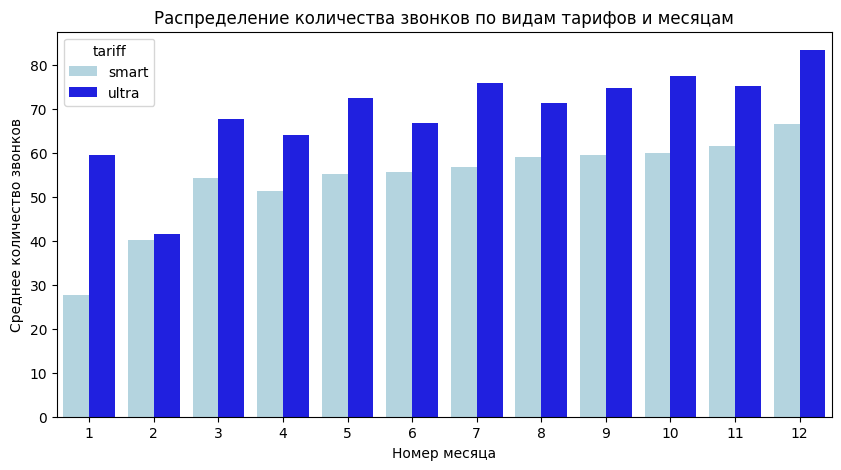

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='month',
            y='calls_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Распределение количества звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество звонков');

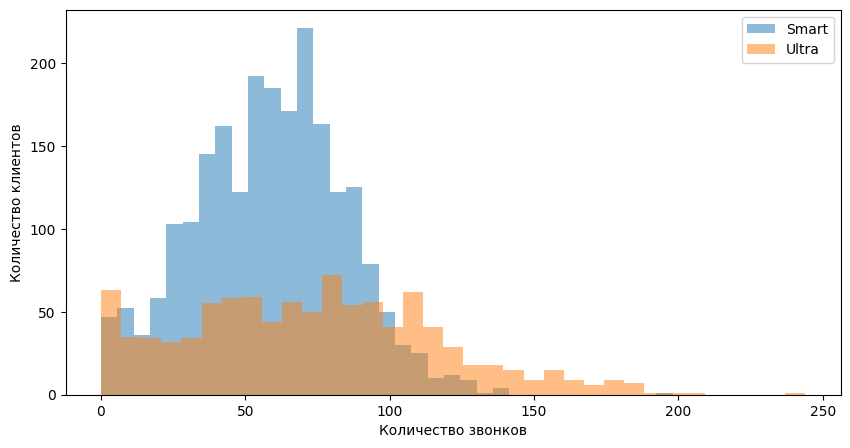

In [35]:
user_behavior.groupby('tariff')['calls'].plot(kind='hist', bins=35, alpha=0.5, figsize=(10,5))
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество звонков')
plt.ylabel('Количество клиентов')
plt.show()

Построим распределение средней продолжительности звонков по видам тарифов и месяцам.

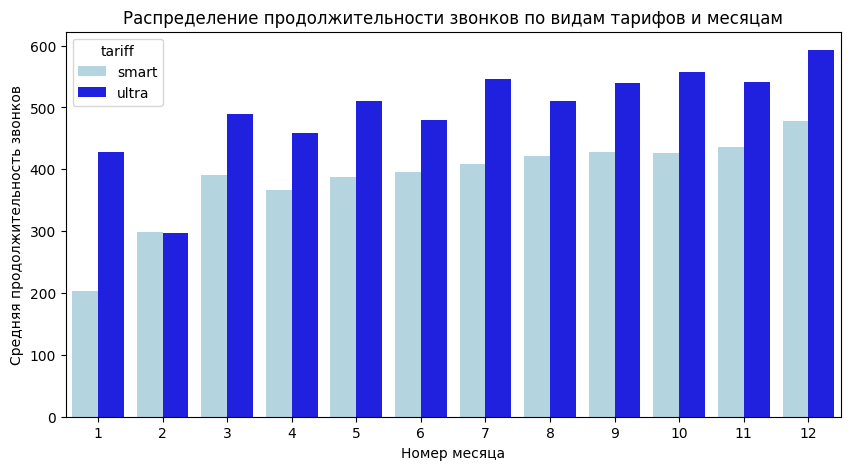

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='month',
            y='minutes_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Распределение продолжительности звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Средняя продолжительность звонков');

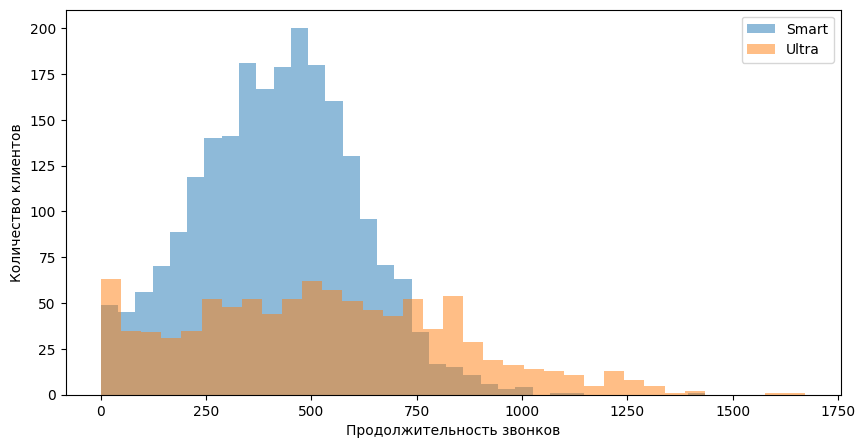

In [37]:
user_behavior.groupby('tariff')['minutes'].plot(kind='hist', bins=35, alpha=0.5, figsize=(10,5))
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Продолжительность звонков')
plt.ylabel('Количество клиентов')
plt.show()

Средняя длительность разговоров у абонентов тарифа `Ультра` больше, чем у абонентов тарифа `Смарт`. В течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров. Рост средней длительности разговоров у абонентов тарифа `Смарт` равномерный в течение года. Пользователи тарифа `Ультра` не проявляют подобной линейной стабильности. Стоит отметить, что феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели.

Построим распределение среднего количества сообщений по видам тарифов и месяцам.

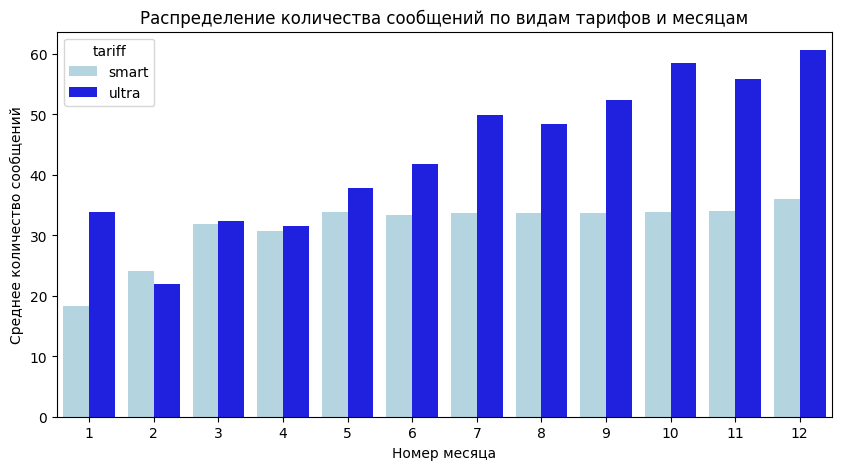

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='month',
            y='messages_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение количества сообщений по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество сообщений');

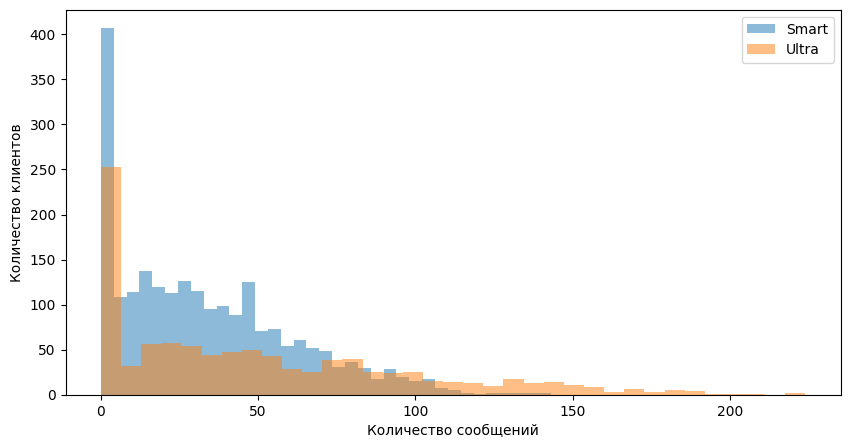

In [39]:
user_behavior.groupby('tariff')['messages'].plot(kind='hist', bins=35, alpha=0.5, figsize=(10,5))
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество сообщений')
plt.ylabel('Количество клиентов')
plt.show()

В среднем количество сообщений пользователи тарифа `Ультра` отправляют больше - почти на 20 сообщений больше, чем пользователи тарифа `Смарт`. Количество сообщений в течение года на обоих тарифах растет. Динамика по отправке сообщений схожа с тенденциями по длительности разговоров: в феврале отмечено наименьшее количество сообщений за год и пользователи тарифа `Ультра` также проявляют нелинейную положительную динамику.

Осталось построить распределение количества потраченного трафика по видам тарифов и месяцам.

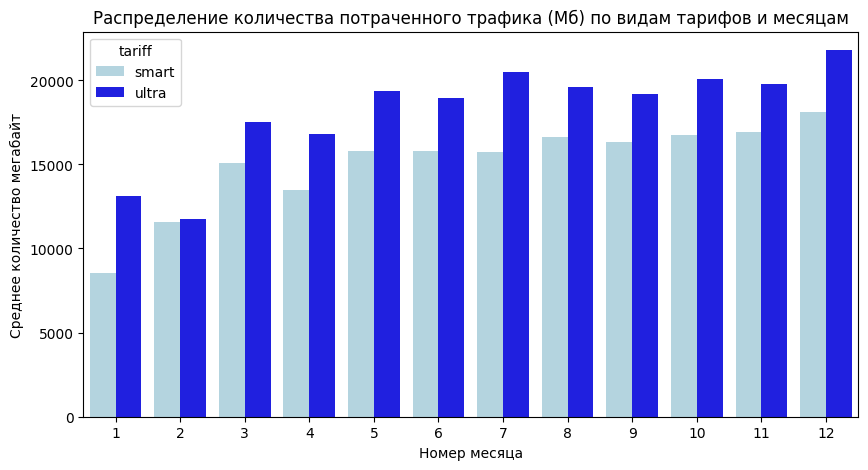

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='month',
            y='sessions_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение количества потраченного трафика (Мб) по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество мегабайт');

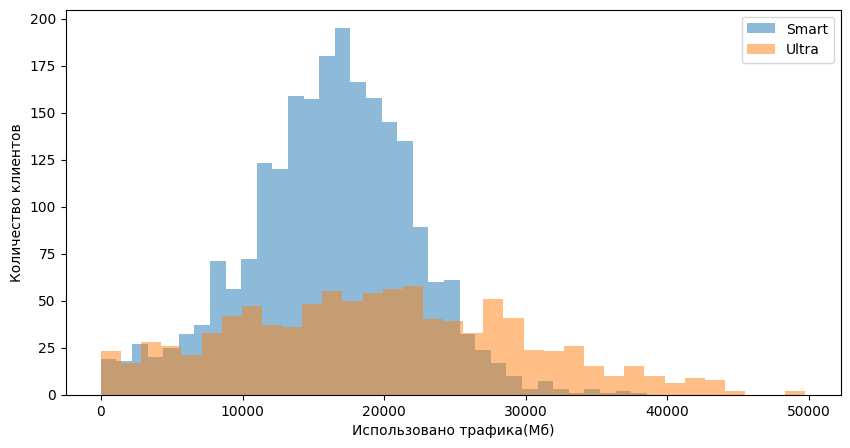

In [41]:
user_behavior.groupby('tariff')['mb_used'].plot(kind='hist', bins=35, alpha=0.5, figsize=(10,5))
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Использовано трафика(Мб)')
plt.ylabel('Количество клиентов')
plt.show()

Меньше всего пользователи использовали интернет в январе, феврале и апреле. Чаще всего абоненты тарифа `Смарт` тратят 15-17 Гб, а абоненты тарифного плана `Ультра` - 19-21 ГБ.

### Предварительные выводы <a class="anchor" id="п_вы"></a>

Выручка от пользователей с тарифом `Ультра` в полтора раза больше, чем от пользователей с тарифом `Смарт`, при этом пользователи с тарифом `Ультра` не расходуют лимит минут и смс и редко выходят за пределы трафика на интернет, в то время как пользователи тарифа `Смарт` переплачивают сверх абоненсткой платы более 750 рублей и в основном за интернет. Видимо это связано с тем, что сообщений и минут разговора в тарифе `Ультра` значительно больше - 1000 сообщений и 3000 минут разговора против 50 сообщений и 500 минут разговора, при том, что продолжительность звонков в месяц редко превышают 500 по обоим тарифам, а количество сообщений - 50. В то же время объём интернет трафика отличается всего в два раза: 30 Гб и 15 Гб соответственно.

Таким образорм можно заключить, что у **пользователей тарифного плана `Ультра` остаётся значительный запас неизрасходованных минут и сообщений, а пользователи тарифного плана `Смарт` приносят выручку в основном докупая дополнительный интернет-трафик**.

Теперь проверим гипотезы о средних значениях выручки пользователей.

## Проверка гипотез <a class="anchor" id="п_г"></a>

У нас сформированы две гипотезы о средней выручке пользователей: *средняя выручка от пользователей тарифов `Ультра` и `Смарт` различаются* и *средняя выручка с пользователей из Москвы отличается от выручки с пользователей других регионов*. Расчёты показали, что для нашей выборки обе гипотезы выглядят правдиво. Теперь необходимо проверить, сохранится ли эта тенденция для *генеральной* совокупности. Для этого составим нулевую и альтернативные гипотезы, проверим гипотезы с помощью `t-теста`, оценив *p-value*.

### Проверка гипотезы: средняя выручка от пользователей тарифов «Ультра» и «Смарт» различается <a class="anchor" id="п_г1"></a>

```
H_0: Выручка (total_cost) от пользователей "Ультра" = выручка (total_cost) от пользователей "Смарт"`
H_1: Выручка (total_cost) от пользователей "Ультра" ≠ выручка (total_cost) от пользователей "Смарт"`
alpha = 0.05
```

In [42]:
df_smart = user_behavior[user_behavior['tariff'] == 'smart']
df_ultra = user_behavior[user_behavior['tariff'] == 'ultra']
alpha = .05

results = st.ttest_ind(df_smart['total_cost'],
                       df_ultra['total_cost'],
                       equal_var = False)

print(round(results.pvalue, 6))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу ')

0.0
Отвергаем нулевую гипотезу


*p-value* очень близко к нулю, что говорит о том, что вероятность получить такое же, как в наших выборках, или большее различие средних значений *случайно*, ровна нулю. Отвергаем нулевую гипотезу и принимаем альтернативную: *средняя выручка от пользователей тарифов `Ультра` и `Смарт` различается*.

### Проверка гипотезы: средняя выручка с пользователей из Москвы отличается от выручки с пользователей других регионов <a class="anchor" id="п_г2"></a>

```
H_0: Выручка (total_cost) от пользователей из Москвы = выручка (total_cost) от пользователей не из Москвы`
H_1: Выручка (total_cost) от пользователей из Москвы ≠ выручка (total_cost) от пользователей не из Москвы`
alpha = 0.05
```

In [43]:
df_Moscow = user_behavior[user_behavior['city'] == 'Москва']
df_not_Moscow = user_behavior[user_behavior['city'] != 'Москва']
alpha = .05

results = st.ttest_ind(df_Moscow['total_cost'],
                       df_not_Moscow['total_cost'],
                       equal_var = False)

print(round(results.pvalue, 6))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу ')

0.525738
Не получилось отвергнуть нулевую гипотезу 


Принимаем нулевую гипотезу: *средняя выручка пользователей из Москвы и пользователей других регионов равны*.

## Вывод <a class="anchor" id="в"></a>

Первая часть исследования привела к следующим выводам:

1. Пользователи тарифа `Смарт` в среднем тратят 1300 рублей на услуги связи, из них 750 рублей сверх ежемесячной платы, 600 из которых приходятся на оплату интернет трафика сверх тарифа.
2. Пользователи тарифа `Ульта` в среднем тратят 2100 рублей на услуги связи, то есть доплачивают всего 150 рублей. Так же пользователей тарифа `Ультра` остаётся значительный запас минут и сообщений.

Учитывая, что соотношение пользователей составляет 70:30, то можно сделать вывод, **что тарифный план `Смарт` приносит больше денег**.
Однако из сказанного ранее можно сделать заключение, что тарифные планы не сбалансированы, тарифный план `Ультра` предлагает очень большой пакет услуг, в то время как пользователям тарифа `Смарт` приходится переплачивать более чем в два раза. Обе ситуации могут привести к снижению удовлетворения клиентов от использования услуг компании и, как следствие, оттоку клиентов.  Необходимо уточнить приоритеты компании для формулирования дальнейших рекомендаций.

Вторая часть состояла из проверки гипотез. Приняты следующие гипотезы:
1. Средняя выручка от пользователей тарифов Ультра и Смарт различается.
2. Средняя выручка пользователей из Москвы и пользователей других регионов равны.